<a href="https://colab.research.google.com/github/charlesdgburns/NM_TinyRNN/blob/main/notebooks/nm_tinyrnn_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's use this as a learning notebook about different RNN architectures.
We want to start from scratch and get an idea of how different architectures work before fitting to some data.


We the fit these to sequential behavioural decision making later.


In [ ]:
## setup on google colab:

!git clone https://github.com/charlesdgburns/NM_TinyRNN.git

Cloning into 'NM_TinyRNN'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 104 (delta 37), reused 55 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 212.00 KiB | 4.93 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
# setup

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import os
CODE_DIR = Path(Path(r'C:\Users\owner\Research'))
os.chdir(CODE_DIR)


In [ ]:
# Train some models using the standard code

from NM_TinyRNN.code.models import training
from NM_TinyRNN.code.models import datasets
from NM_TinyRNN.code.models import rnns
from importlib import reload
reload(training)
reload(datasets)
SAVE_PATH = CODE_DIR/'NM_TinyRNN/data/rnns'
SPARSITY_LAMBDA = 0.0001
DATA_PATH = './NM_TinyRNN/data/AB_behaviour/WS16'
SEQUENCE_LENGTH = 150+1 # Define your desired sequence length
dataset = datasets.AB_Dataset(DATA_PATH, SEQUENCE_LENGTH)
model = rnns.TinyRNN(input_size=3, # past choice, past outcome, past forced choice
                     hidden_size=1, # hidden unit
                     out_size=2, # one-hot code for choice A, choice B
                     rnn_type='GRU', # GRU, LSTM, NMRNN
                sparsity_lambda = SPARSITY_LAMBDA) # Example sizes
trainer = training.Trainer(SAVE_PATH/'GRU')
trainer.fit(model,dataset)

Starting training with 4 sparsity values...
Dataset size: 28
Split sizes - Train: 22, Val: 2, Test: 4

Training with sparsity lambda = 0.01


λ=1e-02: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]



Training with sparsity lambda = 0.001


λ=1e-03: 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]



Training with sparsity lambda = 0.0001


λ=1e-04: 100%|██████████| 10/10 [00:02<00:00,  4.61it/s]



Training with sparsity lambda = 1e-05


λ=1e-05: 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]



Evaluating best model (λ=1e-05) on test set...
Evaluation loss: 0.673868

Training complete!
Best model (λ=1e-05) saved to: C:\Users\owner\Research\NM_TinyRNN\data\rnns\GRU
Best validation loss: 0.676340
Test loss: 0.673868
Lastly, extracting activations on full dataset


,sparsity_lambda,epoch,val_pred_loss,train_pred_loss,train_sparsity_loss
0,0.01000,0,0.688561,0.688144,0.000570
1,0.01000,1,0.685777,0.685254,0.000577
2,0.01000,2,0.683678,0.681928,0.000584
3,0.01000,3,0.682117,0.684018,0.000589
4,0.01000,4,0.680886,0.683521,0.000593
5,0.01000,5,0.679893,0.680334,0.000595
6,0.01000,6,0.679038,0.680134,0.000596
7,0.01000,7,0.678264,0.679861,0.000596
8,0.01000,8,0.677501,0.677641,0.000595
9,0.01000,9,0.676726,0.678914,0.000594


In [64]:
# Extract trial-wise data for visualisation
trials_results = pd.read_csv('./NM_TinyRNN/data/RNNs/GRU/1_unit_GRU_trials_data.htsv', sep='\t')
trials_inputs = dataset.inputs.reshape(-1, 3).numpy().astype(int)
trials_results.loc[:, ["forced_choice","outcome","choice"]] = trials_inputs # "forced_choice","outcome","choice"
trials_results

,hidden_1,gate_reset_1,gate_update_1,logit_value,logit_change,prob_A,prob_b,indices_train,indices_validation,indices_evaluation,session_folder_name,forced_choice,choice,outcome
0,0.243144,0.380321,0.330903,0.234430,NaN,0.558341,0.441659,True,False,False,2025-05-01-164959,1,1,1
1,0.105055,0.239277,0.466727,0.371025,0.136595,0.591707,0.408293,True,False,False,2025-05-01-164959,0,0,1
2,0.438888,0.275564,0.316034,0.040804,-0.330221,0.510200,0.489800,True,False,False,2025-05-01-164959,0,0,0
3,0.566913,0.259348,0.361434,-0.085836,-0.126640,0.478554,0.521446,True,False,False,2025-05-01-164959,0,0,0
4,0.647412,0.226594,0.511286,-0.165464,-0.079628,0.458728,0.541272,True,False,False,2025-05-01-164959,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4195,0.208523,0.231953,0.491598,0.268676,0.196463,0.566768,0.433232,True,False,False,2025-05-14-170159,0,1,1
4196,0.083932,0.240843,0.461493,0.391920,0.123244,0.596745,0.403255,True,False,False,2025-05-14-170159,1,0,0
4197,0.431394,0.276611,0.313266,0.048217,-0.343703,0.512052,0.487948,True,False,False,2025-05-14-170159,0,0,1
4198,0.750898,0.261497,0.356164,-0.267830,-0.316048,0.433440,0.566560,True,False,False,2025-05-14-170159,0,1,1


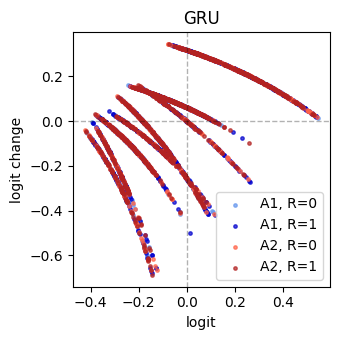

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_phase_portrait_direct(trials_results, s=6, alpha=0.7):
    """
    Plots the phase portrait directly from existing DataFrame columns:
    x = logit_value, y = logit_change.
    """
    # --- 1. Prepare data by dropping rows with no logit_change ---
    df = trials_results.dropna(subset=['logit_value', 'logit_change']).copy()

    # --- 2. Directly use columns to create trial types for coloring ---
    # A1,R=0 -> 0; A1,R=1 -> 1; A2,R=0 -> 2; A2,R=1 -> 3
    df['trial_type'] = df['choice'] * 2 + df['outcome']

    colors = ["cornflowerblue", "mediumblue", "tomato", "firebrick"]

    # --- 3. Plotting ---
    plt.figure(figsize=(3.5, 3.5))

    for tt in range(4):
        mask = (df['trial_type'] == tt)
        label = f'A{tt//2 + 1}, R={tt%2}' # e.g., A1, R=0
        plt.scatter(df.loc[mask, 'logit_value'], df.loc[mask, 'logit_change'],
                    c=colors[tt], s=s, alpha=alpha, label=label)

    # --- 4. Formatting ---

    # Reference lines
    plt.axhline(0, color='k', alpha=0.3, linewidth=1, linestyle='--')
    plt.axvline(0, color='k', alpha=0.3, linewidth=1, linestyle='--')

    plt.xlabel("logit")
    plt.ylabel("logit change")
    plt.title("GRU")
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- Usage ---
plot_phase_portrait_direct(trials_results)